In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

In [100]:
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [101]:
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df.sample(frac=1)[(df.Id != 'new_whale') & (df.sighting_count > 1)].groupby('Id').first().Image)

/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [102]:
val_fns = pd.read_pickle('data/val_fns')

In [103]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [104]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [105]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [106]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [107]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (12766 items)
[Category w_c3d896a, Category w_20df2c5, Category w_dd88965, Category w_64404ac, Category w_a6f9d33]...
Path: data/train
x: ImageItemList (12766 items)
[Image (3, 325, 758), Image (3, 497, 1050), Image (3, 458, 1050), Image (3, 450, 1050), Image (3, 667, 1000)]...
Path: data/train;

Valid: LabelList
y: CategoryList (2931 items)
[Category w_f48451c, Category w_d3b46e7, Category w_8cad422, Category w_13ae3d4, Category w_8dddbee]...
Path: data/train
x: ImageItemList (2931 items)
[Image (3, 700, 1050), Image (3, 347, 1050), Image (3, 525, 918), Image (3, 525, 1050), Image (3, 450, 900)]...
Path: data/train;

Test: LabelList
y: EmptyLabelList (7960 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7960 items)
[Image (3, 510, 1050), Image (3, 600, 1050), Image (3, 600, 1050), Image (3, 700, 1050), Image (3, 244, 1050)]...
Path: data/train

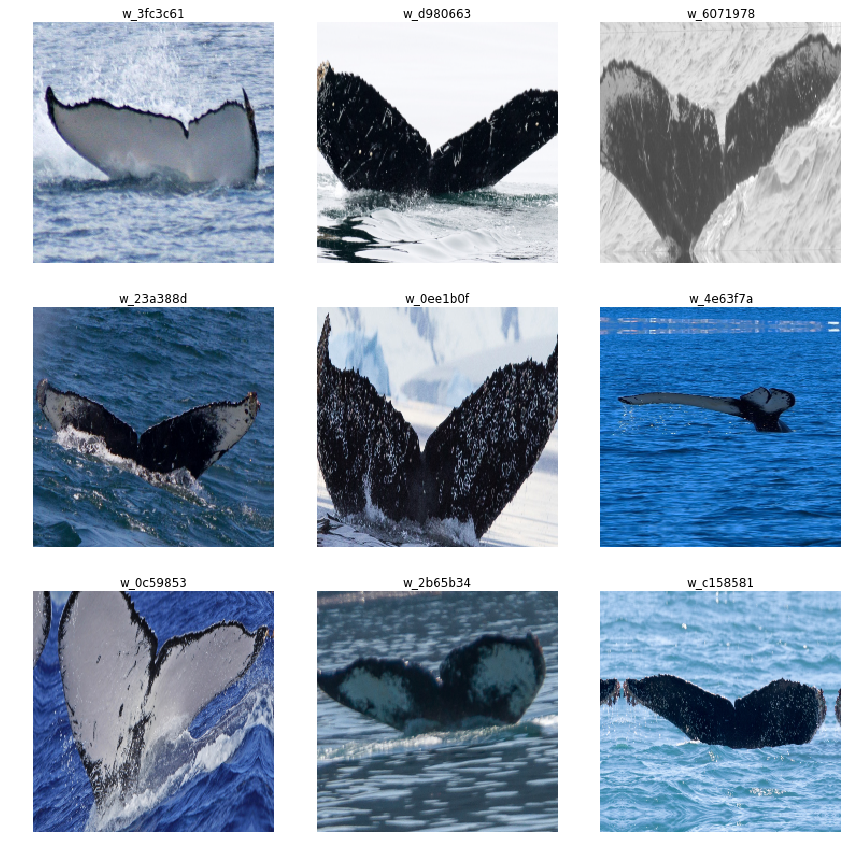

In [12]:
data.show_batch(rows=3)

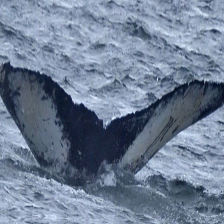

In [16]:
data.train_ds[1][0]

In [17]:
name = f'res50-tuned-{SZ}'

In [19]:
# transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
learn.clip_grad();

learn.fit_one_cycle(12, 1e-2)

learn.unfreeze()

max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,7.479638,7.940562,0.034118,0.047953
2,6.891355,8.278144,0.034459,0.051058
3,6.306304,7.873838,0.044012,0.065285
4,5.256508,6.912084,0.093825,0.128358
5,4.387443,5.967416,0.154896,0.196946
6,3.457472,5.226291,0.234391,0.286751
7,2.485574,4.814858,0.282839,0.342648
8,1.530134,4.466634,0.350734,0.410099
9,0.818946,4.279766,0.390652,0.444905
10,0.381630,4.194751,0.406005,0.460565


epoch,train_loss,valid_loss,accuracy,map5
1,0.132511,4.022673,0.422723,0.480240
2,0.158464,4.103366,0.415899,0.473507
3,0.211098,4.208995,0.401569,0.461498
4,0.280802,4.282731,0.386899,0.449465
5,0.347358,4.266278,0.389628,0.448288
6,0.380470,4.429554,0.373251,0.436745
7,0.337011,4.315244,0.400887,0.461703
8,0.293165,4.200620,0.411122,0.467036
9,0.266888,4.244209,0.412487,0.470266
10,0.233547,4.290638,0.408052,0.469055


In [20]:

# learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
# learn.clip_grad();

# learn.fit_one_cycle(12, 1e-2)

# learn.unfreeze()

# max_lr = 1e-3
# lrs = [max_lr/100, max_lr/10, max_lr]

# learn.fit_one_cycle(20, lrs)
learn.save('tmp')

In [21]:
SZ = 224 * 2
BS = 64 // 4
NUM_WORKERS = 12
SEED=0

In [54]:
df = pd.read_csv('data/oversampled_train.csv')

In [55]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [56]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (76174 items)
[Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639]...
Path: data/train
x: ImageItemList (76174 items)
[Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050), Image (3, 700, 1050)]...
Path: data/train;

Valid: LabelList
y: CategoryList (2931 items)
[Category w_cb622a2, Category w_d3b46e7, Category w_13ae3d4, Category w_c0d11da, Category w_cee684e]...
Path: data/train
x: ImageItemList (2931 items)
[Image (3, 285, 1050), Image (3, 347, 1050), Image (3, 525, 1050), Image (3, 690, 1050), Image (3, 600, 1050)]...
Path: data/train;

Test: LabelList
y: EmptyLabelList (7960 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7960 items)
[Image (3, 510, 1050), Image (3, 600, 1050), Image (3, 600, 1050), Image (3, 700, 1050), Image (3, 244, 1050)]...
Path: data/train

In [24]:
%%time
# SZ = 448
# transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
# oversampled without val

learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], lin_ftrs=[2048])
learn.clip_grad();
learn.load('tmp');
learn.freeze_to(-1)

learn.fit_one_cycle(2, 1e-2 / 4)

learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,0.965003,3.891992,0.430229,0.485221
2,0.341033,3.011763,0.546912,0.597657


epoch,train_loss,valid_loss,accuracy,map5
1,0.296372,3.006887,0.550324,0.599511
2,0.184964,2.803148,0.579324,0.626004
3,0.118156,2.734234,0.586489,0.633481


CPU times: user 1h 11min 37s, sys: 29min 7s, total: 1h 40min 44s
Wall time: 1h 40min 53s


In [131]:
learn.save('okr')

In [132]:
df = pd.read_csv('data/train.csv')

In [133]:
df.shape

(25361, 2)

In [138]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:1000])
len(new_whale_fns)

1000

In [135]:
data = (
    ImageItemList
        .from_df(df, 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns))
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=learn.data.classes)
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your train set contained the folowing unknown labels, the corresponding items have been discarded.
new_whale
  if getattr(ds, 'warn', False): warn(ds.warn)
/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the folowing unknown labels, the corresponding items have been discarded.
new_whale
  if getattr(ds, 'warn', False): warn(ds.warn)


In [136]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (12766 items)
[Category w_c3d896a, Category w_20df2c5, Category w_dd88965, Category w_64404ac, Category w_a6f9d33]...
Path: data/train
x: ImageItemList (12766 items)
[Image (3, 325, 758), Image (3, 497, 1050), Image (3, 458, 1050), Image (3, 450, 1050), Image (3, 667, 1000)]...
Path: data/train;

Valid: LabelList
y: CategoryList (2931 items)
[Category w_f48451c, Category w_d3b46e7, Category w_8cad422, Category w_13ae3d4, Category w_8dddbee]...
Path: data/train
x: ImageItemList (2931 items)
[Image (3, 700, 1050), Image (3, 347, 1050), Image (3, 525, 918), Image (3, 525, 1050), Image (3, 450, 900)]...
Path: data/train;

Test: LabelList
y: EmptyLabelList (7960 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7960 items)
[Image (3, 510, 1050), Image (3, 600, 1050), Image (3, 600, 1050), Image (3, 700, 1050), Image (3, 244, 1050)]...
Path: data/train

In [113]:
learn.data = data

In [114]:
preds, _ = learn.get_preds(DatasetType.Valid)

In [115]:
classes = learn.data.classes + ['new_whale']

In [116]:
targs = torch.tensor([classes.index(label.obj) if label else 5004 for label in learn.data.valid_ds.y])

In [117]:
# without predicting new_whale
map5(preds, targs)

tensor(0.6910)

In [118]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [119]:


# always predicting new_whale with probability = 1
map5(preds, targs)



tensor(0.3544)

In [120]:
%%time
res = []
ps = np.linspace(0, 1, 51)
for p in ps:
    preds[:, 5004] = p
    res.append(map5(preds, targs).item())

CPU times: user 47 s, sys: 2.36 s, total: 49.3 s
Wall time: 49.3 s


In [121]:
best_p = ps[np.argmax(res)]; best_p

0.0

In [122]:
preds[:, 5004] = best_p

In [123]:
map5(preds, targs)

tensor(0.6910)

In [124]:
preds, _ = learn.get_preds(DatasetType.Test)

In [125]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [126]:
preds[:, 5004] = best_p

In [127]:
def create_submission(preds, data, name, no_bbox_test_images=None,classes=None):
    if not classes: classes = data.classes
    images = [path.name for path in data.test_ds.x.items]
    if no_bbox_test_images:
        images.extend(no_bbox_test_images)
    
    sub = pd.DataFrame({'Image': images})
    top5 = top_5_pred_labels(preds, classes)
    if no_bbox_test_images:
        top5.extend([' '.join(['new_whale', 'new_whale','new_whale','new_whale','new_whale']) for n in no_bbox_test_images])
    sub['Id'] = top5
    sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')
create_submission(preds, learn.data, name, classes)

In [128]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,a3e2f1961.jpg,w_4312b77 w_94e8c02 w_9490369 w_6d80008 w_6fd2888
1,67cb588bb.jpg,w_91cc02c w_77c86af w_953b7b2 w_0f00df0 w_8ef9b33
2,519db8bd9.jpg,w_27a6304 w_a1d016d w_5645ed1 w_317c071 w_8fad4d2
3,1e5d52a28.jpg,w_08753b7 w_a9304b9 w_04003e9 w_a87ec7e w_a2a40d2
4,809da6dd7.jpg,w_59052ad w_90df70c w_5778858 w_6279534 w_b6e4761


In [129]:
pd.read_csv(f'subs/{name}.csv.gz').shape

(12965, 2)

In [130]:
pd.read_csv(f'subs/{name}.csv.gz').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.38603933667566526

In [79]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|████████████████████████████████████████| 225k/225k [00:04<00:00, 50.5kB/s]
Successfully submitted to Humpback Whale Identification